# SCC0277: Desafio de Séries Temporais

Dikson F. Santos `<dikson@usp.br>`

`(github.com/diksown/wind-whisper)`


## Introdução


...


## Pré-processamento


### Inicialização dos dados


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import EnsembleForecaster

In [2]:
def read_time_series(csv_path):
    df = pd.read_csv(csv_path)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    return df

In [3]:
df = read_time_series("data/DailyDelhiClimateTrain.csv")
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


Não faltam valores! Maravilha.


In [5]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Data visualization


In [6]:
def feature_along_time(df, feature_title, feature_name, unit):
    plt.figure(figsize=(9, 3))
    plt.plot(df[feature_name])
    plt.title(feature_title)
    plt.ylabel(unit)
    plt.show()

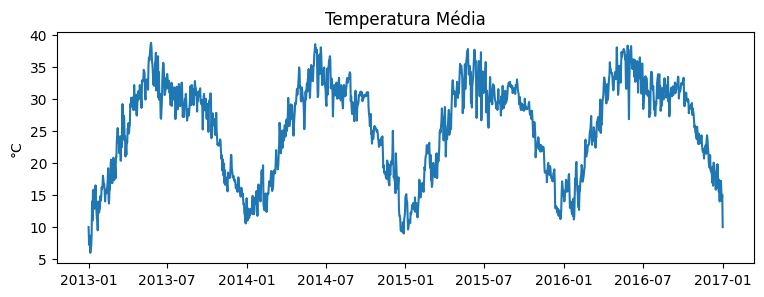

In [7]:
feature_along_time(df, "Temperatura Média", "meantemp", "°C")

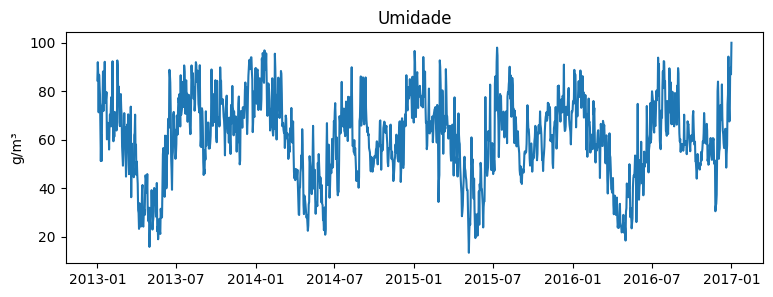

In [8]:
feature_along_time(df, "Umidade", "humidity", "g/m³")

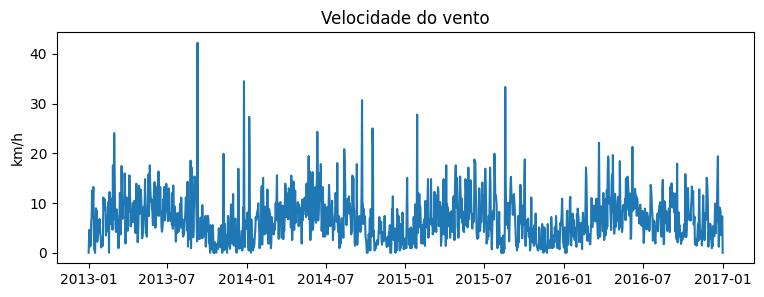

In [9]:
feature_along_time(df, "Velocidade do vento", "wind_speed", "km/h")

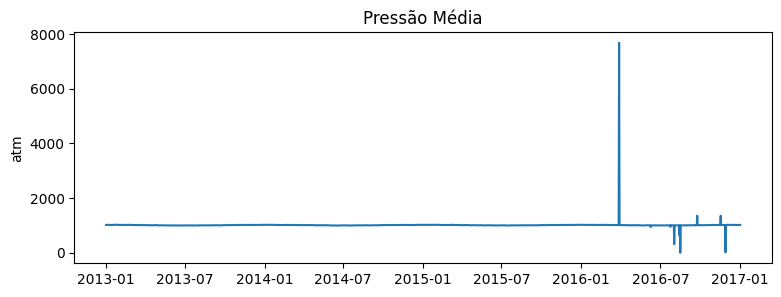

In [10]:
feature_along_time(df, "Pressão Média", "meanpressure", "atm")

In [11]:
def remove_outliers(df):
    Q1 = df["meanpressure"].quantile(0.25)
    Q3 = df["meanpressure"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df["meanpressure"] >= lower_bound) & (df["meanpressure"] <= upper_bound)]

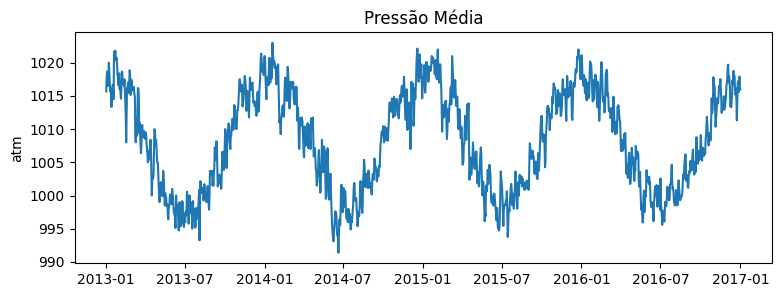

In [12]:
df = remove_outliers(df)
feature_along_time(df, "Pressão Média", "meanpressure", "atm")

## Predição


In [13]:
def get_y(df, col="meantemp"):
    df_copy = df.copy()
    df_copy.index = df_copy.index.to_period("D")
    return df_copy[col]

In [14]:
df_test = read_time_series("data/DailyDelhiClimateTest.csv")

y_train = get_y(df)
y_test = get_y(df_test)
y = pd.concat([y_train, y_test])

In [15]:
def evaluate_forecaster(forecaster, forecaster_name):
    fh = np.arange(len(y_test)) + 1
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    print(f"{forecaster_name}")
    print(
        f"MAE: {mean_absolute_percentage_error(y_test, y_pred):.2f}",
    )
    print(f"RMSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"SMAPE: {mean_absolute_percentage_error(y_test, y_pred):.2f}")
    print()

### Naive Forescaster


In [16]:
evaluate_forecaster(NaiveForecaster(strategy="last"), "Naive (Last)")

Naive (Last)
MAE: 0.50
RMSE: 177.29
SMAPE: 0.50



In [17]:
evaluate_forecaster(NaiveForecaster(strategy="mean"), "Naive (Mean)")

Naive (Mean)
MAE: 0.37
RMSE: 55.06
SMAPE: 0.37



In [18]:
evaluate_forecaster(NaiveForecaster(strategy="drift"), "Naive (Drift)")

Naive (Drift)
MAE: 0.50
RMSE: 178.48
SMAPE: 0.50



### Auto ETS


In [19]:
evaluate_forecaster(AutoETS(auto=True, sp=4), "AutoETS")

AutoETS
MAE: 0.45
RMSE: 153.36
SMAPE: 0.45



### Arima


In [20]:
evaluate_forecaster(AutoARIMA(sp=4, suppress_warnings=True), "AutoARIMA")

AutoARIMA
MAE: 0.43
RMSE: 157.48
SMAPE: 0.43



### Ensemble


In [21]:
evaluate_forecaster(
    EnsembleForecaster(
        [
            ("AutoETS", AutoETS(auto=True, sp=4)),
            ("AutoArima", AutoARIMA(sp=4, suppress_warnings=True)),
        ],
        n_jobs=-1,
    ),
    "EnsembleForecaster",
)

EnsembleForecaster
MAE: 0.44
RMSE: 155.27
SMAPE: 0.44

